# SOEN471-PROJECT - Suicide and Depression Sentiment Analysis - Team 13

## Librairies

In [36]:
# !pip install keras
# !pip install tensorflow
# !pip install pyarrow
import os
import numpy as np
import dask.dataframe as df
import seaborn as sns
import matplotlib.pyplot as plt
import neattext.functions as nfx
import re
import dask_ml.model_selection as dcv
import nltk
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
import pandas as pd
import pickle





     ---------------------------------------- 20.6/20.6 MB 1.0 MB/s eta 0:00:00


## Load Data

In [7]:
dask = df.read_csv(os.path.join('.', 'data', 'Suicide_Detection.csv'))
print(len(dask))

232074


## Previewing Data

In [8]:
dask.compute()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...,...
115912,348103,If you don't like rock then your not going to ...,non-suicide
115913,348106,You how you can tell i have so many friends an...,non-suicide
115914,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
115915,348108,The usual stuff you find hereI'm not posting t...,suicide


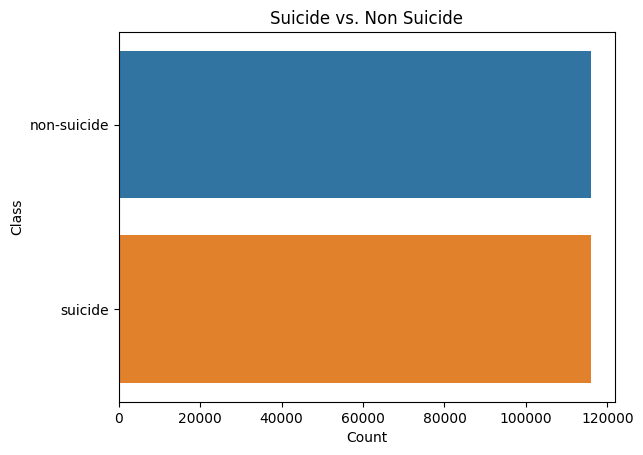

In [9]:

# Count the values in the 'class' column
class_counts = dask['class'].value_counts().compute()


# Create a bar plot of the value counts using Seaborn
sns.barplot(x=class_counts.values, y=class_counts.index)

# Add a title, x-label, and y-label to the plot
plt.title('Suicide vs. Non Suicide')
plt.xlabel('Count')
plt.ylabel('Class')

# Show the plot
plt.show()



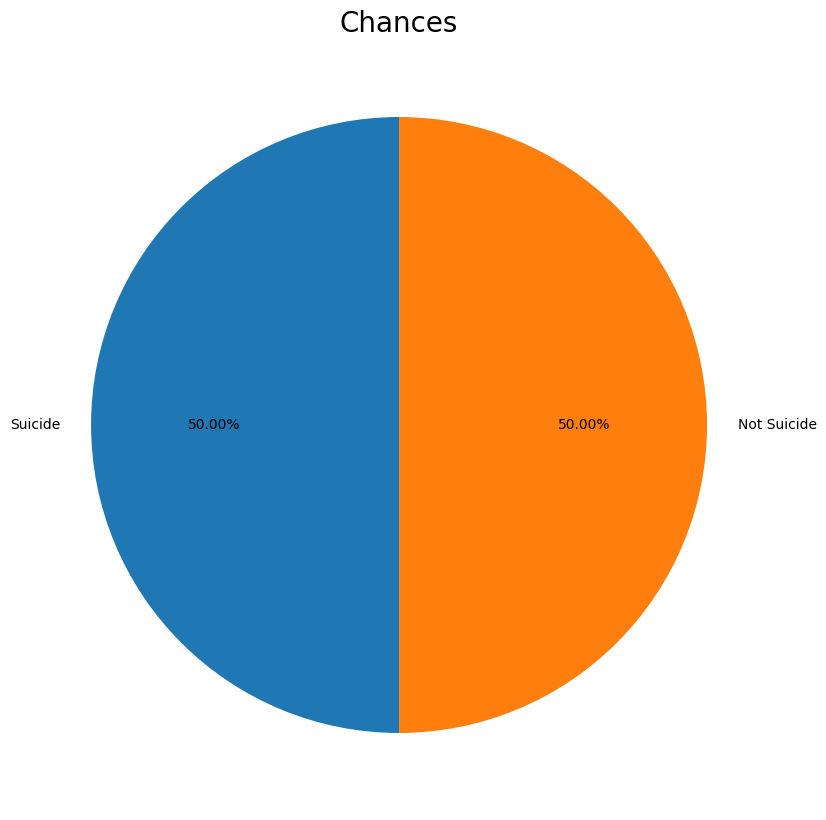

In [10]:
# Creating a pie chart to more accurate display the 50/50 split of the dataset 
plt.figure(figsize=(12,10))
plt.pie(dask['class'].value_counts(),startangle=90, autopct='%0.2f%%',labels=['Suicide','Not Suicide'])
plt.title('Chances',fontdict={'size':20})
plt.show()

# Preprocessing Data

In [11]:
# Deleting Unnamed 0 column since its useless

dask = dask.drop('Unnamed: 0', axis=1)

In [12]:
# Check for missing values in each column
missing_values = dask.isnull().sum()

# Compute the results
results = missing_values.compute()

# Print the number of missing values in each column
for column, count in results.items():
    print(f"Column '{column}' has {count} missing values.")

Column 'text' has 0 missing values.
Column 'class' has 0 missing values.


In [13]:
# Make lowercase
dask['text'] = dask['text'].str.lower()

dask.head()

,text,class
0,ex wife threatening suiciderecently i left my ...,suicide
1,am i weird i don't get affected by compliments...,non-suicide
2,finally 2020 is almost over... so i can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"i’m so losthello, my name is adam (16) and i’v...",suicide


In [14]:
# Remove all the special characters from the dataset (only keeping number, letters and whitespaces)

dask['text'] = dask['text'].apply(nfx.remove_special_characters, meta=('text', 'object'))
dask.head()


,text,class
0,ex wife threatening suiciderecently i left my ...,suicide
1,am i weird i dont get affected by compliments ...,non-suicide
2,finally 2020 is almost over so i can never hea...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,im so losthello my name is adam 16 and ive bee...,suicide


In [15]:
# Removing stopwords such as the, and, a, but e.t.c

dask['text'] = dask['text'].apply(nfx.remove_stopwords, meta=('text', 'object'))
dask.head()

,text,class
0,ex wife threatening suiciderecently left wife ...,suicide
1,weird dont affected compliments coming know ir...,non-suicide
2,finally 2020 hear 2020 bad year swear fucking ...,non-suicide
3,need helpjust help im crying hard,suicide
4,im losthello adam 16 ive struggling years im a...,suicide


In [16]:
def split_concatenated_words(text):
    pattern = r'([a-zA-Z]+)(\d+)?'
    matches = re.findall(pattern, text)
    for match in matches:
        text = text.replace(''.join(match), ' '.join(match))
    return text.strip()

In [17]:
# Apply lambda function to remove the concatenated words

dask['text'] = dask['text'].apply(lambda x: split_concatenated_words(x), meta=('text', 'object'))

# Print the result
print(dask.compute())

                                                     text        class
0       ex  wife    threaten ing   suicide recently  l...      suicide
1       weird  dont  affected  compliments  coming  kn...  non-suicide
2       finally  2020 hear  2020 bad  year  swear  fuc...  non-suicide
3                 need  help just  help  im  crying  hard      suicide
4       im        lost hello  adam  16 ive            ...      suicide
...                                                   ...          ...
115912  dont  like  rock  going  httpsmusictastespacem...  non-suicide
115913  tell  friends  lonely  deprived  prebought  li...  non-suicide
115914  pee   probably  tastes  like  salty  tea  dran...  non-suicide
115915  usual  stuff   find  hereim      post ing  sym...      suicide
115916  havent  beaten  boss  hollow  knight  ive  fou...  non-suicide

[232074 rows x 2 columns]


In [18]:
# Remove whitespace from the column 
dask['text'] = dask['text'].apply(lambda x: re.sub('\s+', ' ', x).strip(), meta=('text', 'object'))

print(dask.compute())

                                                     text        class
0       ex wife threaten ing suicide recently left wif...      suicide
1       weird dont affected compliments coming know ir...  non-suicide
2       finally 2020 hear 2020 bad year swear fucking ...  non-suicide
3                      need help just help im crying hard      suicide
4       im lost hello adam 16 ive struggling years im ...      suicide
...                                                   ...          ...
115912  dont like rock going httpsmusictastespacematch...  non-suicide
115913  tell friends lonely deprived prebought little ...  non-suicide
115914  pee probably tastes like salty tea drank pee c...  non-suicide
115915  usual stuff find hereim post ing sympathy pity...      suicide
115916  havent beaten boss hollow knight ive fought ti...  non-suicide

[232074 rows x 2 columns]


In [19]:
# Removing punctuations
dask['text'] = dask['text'].apply(nfx.remove_puncts, meta=('text', 'object'))

# Removing emojis
dask['text'] = dask['text'].apply(nfx.remove_emojis, meta=('text', 'object'))

# Remove currency symbols
dask['text'] = dask['text'].apply(nfx.remove_currency_symbols, meta=('text', 'object'))

# Remove emails
dask['text'] = dask['text'].apply(nfx.remove_emails, meta=('text', 'object'))





In [22]:
# Lemmatize the column 

lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

# Define a function to lemmatize a text string
def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ali\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [23]:
# Lemmatize the text column
dask['text'] = dask['text'].map_partitions(lambda partition: partition.apply(lambda row: lemmatize_text(row)))


In [39]:
# Create a pickle file
with open("data.pickle", 'wb') as f:
    pickle.dump(dask.compute(), f, protocol=pickle.HIGHEST_PROTOCOL)


## Training Data

In [24]:
X = dask.drop('class', axis=1)
y = dask['class']

X_train, X_test, y_train, y_test = dcv.train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [25]:
# Tokenize the column

token = Tokenizer()

token.fit_on_texts(X_train)



ValueError: 'label' must be of length 'x'

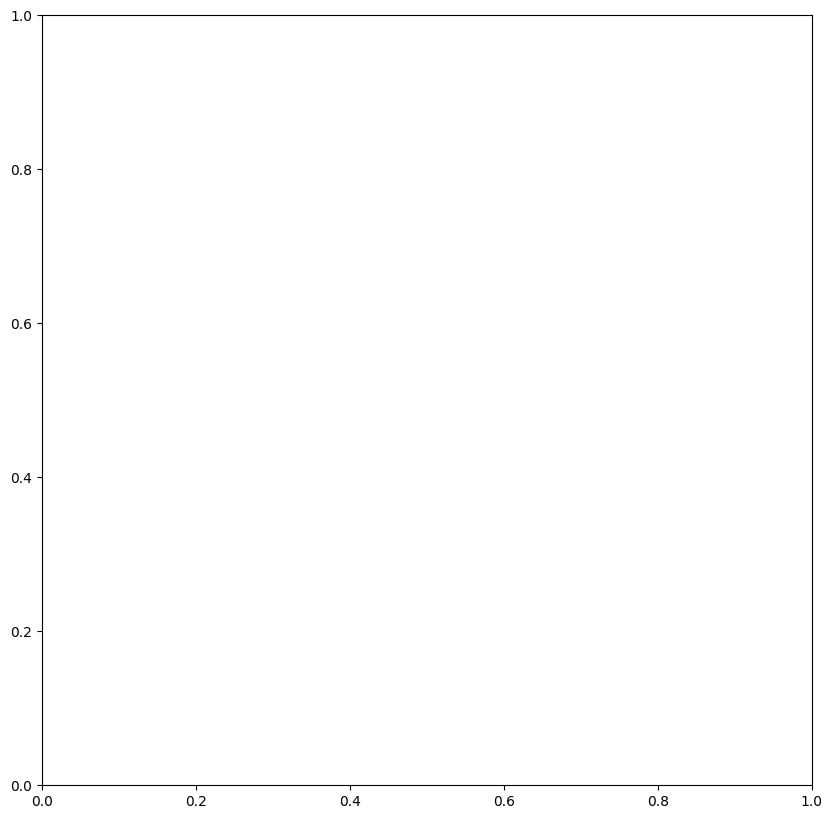

In [27]:
plt.figure(figsize=(12,10))
plt.pie(y_train['class'].value_counts(),startangle=90, autopct='%0.2f%%',labels=['Suicide','Not Suicide'])
plt.title('Chances',fontdict={'size':20})
plt.show()